# 🎯 Goal
주어진 daily sales data 에 대해, 다음 달의 모든 product 에 대한 total sales 를 예측하라.

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import statsmodels.api as sm
from scipy import stats

# Settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = './input/'
dirs = os.listdir(path)
for file in dirs:
    print(file)

items.csv
item_categories.csv
sales_train.csv
sample_submission.csv
shops.csv
test.csv


In [3]:
# Import Files
raw_sales = pd.read_csv('./input/sales_train.csv')
item_cat = pd.read_csv('./input/item_categories.csv')
item = pd.read_csv('./input/items.csv')
sub = pd.read_csv('./input/sample_submission.csv')
shops = pd.read_csv('./input/shops.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
raw_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
raw_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
raw_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


`date` 컬럼이 dd.mm.yyyy 순으로 되어 있는 형태이지만, 데이터 타입은 object 로 인식되고 있다. 날짜를 다루기 위해 포매팅하자.

In [7]:
sales = raw_sales.copy()
sales['date'] = raw_sales['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


# 🔎 EDA

In [8]:
list(sales.columns)

['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']

In [9]:
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### 이상치 확인
결측치는 존재하지 않는다. 컬럼별 이상치가 있는지 확인한다.

In [10]:
for col in sales.columns:
    print("#### Column name : %s####" %col)
    print(sales[col].describe(), "\n")

#### Column name : date####
count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object 

#### Column name : date_block_num####
count    2.935849e+06
mean     1.456991e+01
std      9.422988e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64 

#### Column name : shop_id####
count    2.935849e+06
mean     3.300173e+01
std      1.622697e+01
min      0.000000e+00
25%      2.200000e+01
50%      3.100000e+01
75%      4.700000e+01
max      5.900000e+01
Name: shop_id, dtype: float64 

#### Column name : item_id####
count    2.935849e+06
mean     1.019723e+04
std      6.324297e+03
min      0.000000e+00
25%      4.476000e+03
50%      9.343000e+03
75%      1.568400e+04
max      2.216900e+04
Name: item_id, dtype: float64 

#### Column name : item_price####

In [11]:
sales['item_cnt_day'].sort_values().head()

1057907   -22.0
1835454   -16.0
2048519    -9.0
59156      -6.0
940092     -6.0
Name: item_cnt_day, dtype: float64

In [12]:
sales['item_price'].sort_values().head()

484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

`item_cnt_day`와 `item_price`는 각각 일별 판매량과 상품 가격을 의미하므로 음수가 나올 수 없다.

In [13]:
print("item_cnt_day : %s cases are counted as negative, \nwhich is %.3f%% of whole data" %(sum(sales['item_cnt_day'] < 0),
                                                                            sum(sales['item_cnt_day']<0)/len(sales)*100))
print("item_price : %s cases are counted as negative, \nwhich is %.3f%% of whole data" %(sum(sales['item_price'] < 0),
                                                                            sum(sales['item_price']<0)/len(sales)*100))

item_cnt_day : 7356 cases are counted as negative, 
which is 0.251% of whole data
item_price : 1 cases are counted as negative, 
which is 0.000% of whole data


`item_cnt_day`의 경우 절댓값을 취해 양수가 될 수 있도록 한다.

In [14]:
sales['item_cnt_day'] = np.abs(sales['item_cnt_day'])

`item_price`의 경우, 음수가 1개의 경우만 발견되었기 때문에 삭제한다.

In [15]:
len(sales)

2935849

In [16]:
sales = sales[sales['item_price']>0]

In [17]:
len(sales)

2935848

In [18]:
sales['item_cnt_day'].describe()

count    2.935848e+06
mean     1.247778e+00
std      2.616391e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [19]:
sales['item_price'].describe()

count    2.935848e+06
mean     8.908535e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

판매되는 상품 가격의 분포를 살펴보자.

<AxesSubplot:>

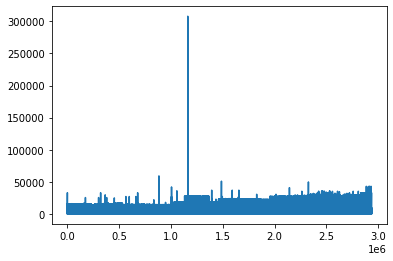

In [20]:
sales['item_price'].plot()

In [21]:
maximum_price = sales[sales['item_price']==sales['item_price'].max()]
maximum_price_item = item[item['item_id']==int(maximum_price.item_id.values)]

In [22]:
maximum_price

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


307,980루블(한화 약 4,800,000원)의 상품 1개가 결제되었다.

In [23]:
maximum_price_item

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


해당 상품의 카테고리는 가정 및 사무실용 프로그램이다.

In [24]:
item_cat[item_cat['item_category_id']==int(maximum_price_item.item_category_id.values)]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


매 월별 가장 많이 팔린 상품의 카테고리를 확인해 보자.

In [25]:
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['date', 'item_price', 'item_cnt_day'].agg(
    {'date':['min', 'max'], 'item_price':'mean', 'item_cnt_day':'sum'}
)
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [26]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
top_10_monthly_sales = x.iloc[0:10].reset_index() # Top 10 Counts
top_10_monthly_sales

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


Text(0, 0.5, '# of items')

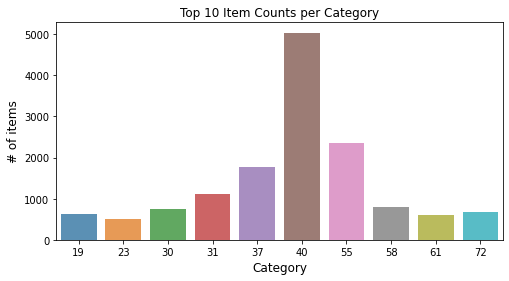

In [27]:
plt.figure(figsize=(8,4))
ax = sns.barplot(top_10_monthly_sales.item_category_id, top_10_monthly_sales.item_id, alpha=0.8)
plt.title('Top 10 Item Counts per Category')
plt.xlabel('Category', fontsize=12)
plt.ylabel('# of items', fontsize=12)

In [28]:
for category in top_10_monthly_sales['item_category_id']:
    print(item_cat[item_cat['item_category_id']==category].item_category_name.values)

['Кино - DVD']
['Музыка - CD локального производства']
['Кино - Blu-Ray']
['Игры PC - Цифра']
['Музыка - Винил']
['Игры PC - Стандартные издания']
['Подарки - Фигурки']
['Игры - PS3']
['Подарки - Атрибутика']
['Игры - XBOX 360']


가장 많이 팔린 상품 카테고리는 영화(Кино)이다.

# ⏰ Time Series EDA
## 시계열 분해
월별 상품 구매량의 시계열적인 추세를 분해해 보자.

In [29]:
sales_by_month = sales.copy()
sales_by_month = sales_by_month.set_index('date')

In [30]:
sales_by_month = sales_by_month.item_cnt_day.resample('M').sum()
sales_by_month.head()

date
2013-01-31    132221.0
2013-02-28    128674.0
2013-03-31    147734.0
2013-04-30    107688.0
2013-05-31    107325.0
Freq: M, Name: item_cnt_day, dtype: float64

<Figure size 2160x864 with 0 Axes>

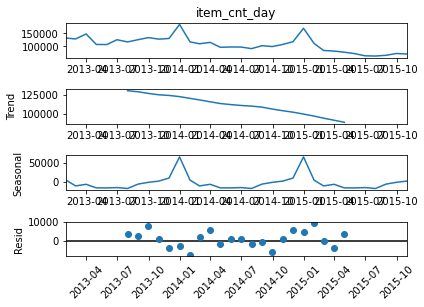

In [31]:
## Additive model
plt.figure(figsize=(30, 12))
decomposition = sm.tsa.seasonal_decompose(sales_by_month, model='additive')
fig = decomposition.plot()
plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=11)
plt.show()

<Figure size 2160x864 with 0 Axes>

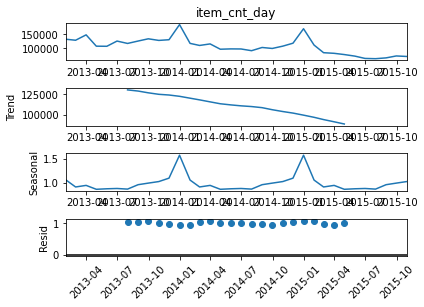

In [32]:
## Multiplicative model
plt.figure(figsize=(30, 12))
decomposition = sm.tsa.seasonal_decompose(sales_by_month, model='multiplicative')
fig = decomposition.plot()
plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=11)
plt.show()

`additive` : 시계열적 특성을 가진 데이터를 trend + seasonality + noise 의 결과로 보고 분해하는 모델로, 계절성의 규모가 시간에 따라 변화하는 경향이 존재하지 않을 때 사용한다.

`multiplicative` : 시계열적 특성을 가진 데이터를 trend * seasonality * noise 의 결과로 보고 분해하는 모델로, 계절성의 규모가 시간에 따라 변화하는 경향이 존재할 때 사용한다.

- 점진적으로 감소하는 추세
- 계절별 주기성이 발견되지 않음

# ⚙ Feature Engineering

## 중복 데이터 제거

In [33]:
train = sales.copy()

In [34]:
subset = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)
print('train shape :',train.shape)

False    2935842
True           6
dtype: int64
train shape : (2935842, 6)


## `item_group` : 상품 카테고리가 속해 있는 범주 만들기

In [35]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [36]:
item_cat.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


`item_category_name`에서 맨 앞에 해당하는 단어가 더 큰 범주의 카테고리를 의미한다. 예를 들어 `Аксессуары - PS2`, `Аксессуары - PS3`.. 은 `Аксессуары`(부속품) 카테고리에 속해 있다. `item_category_name`을 공백을 기준으로 나누고, 첫 번째 단어를 기준으로 `item_group`을 나눈다. 이후 `item_category_name` 컬럼을 삭제한다.

In [37]:
item_grep = item_cat['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_cat['item_group'] = pd.Categorical(item_grep).codes

In [38]:
item = pd.merge(item, item_cat.loc[:, ['item_category_id', 'item_group']], on=['item_category_id'], how='left')
item.drop(['item_category_id'], axis=1, inplace=True)

In [39]:
item.head()

,item_name,item_id,item_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,11
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,7
4,***КОРОБКА (СТЕКЛО) D,4,7


## `city` : 도시명 feature 만들기

In [40]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


`shop_name`의 첫 번째 단어가 상점의 지역명을 의미한다. 특수문자 `!`을 공백으로 대체하고, 맨 첫 번째 단어를 가져온다.

In [41]:
city = shops.shop_name.apply(lambda x: str.replace(x, '!','')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


## 지난 달의 판매를 Feature 로 생성

In [42]:
train['item_cnt_day_lag1'] = train['item_cnt_day'].shift(1)
train['item_cnt_day_lag7'] = train['item_cnt_day'].shift(7)
train['item_cnt_day_lag1'].fillna(method='bfill', inplace=True)
train['item_cnt_day_lag7'].fillna(method='bfill', inplace=True)

## 데이터프레임 합치기

In [43]:
train = pd.merge(train, item, on=['item_id'], how='left').drop('item_name', axis=1)

In [44]:
train = pd.merge(train, shops, on=['shop_id'], how='left').drop(['shop_name', 'city'], axis=1)

## 범주형 변수 인코딩하기

In [45]:
train = pd.get_dummies(train, columns=['item_group'])

In [46]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_day_lag1,item_cnt_day_lag7,item_group_0,item_group_1,...,item_group_5,item_group_6,item_group_7,item_group_8,item_group_9,item_group_10,item_group_11,item_group_12,item_group_13,item_group_14
0,2013-01-02,0,59,22154,999.00,1.0,1.0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2013-01-03,0,25,2552,899.00,1.0,1.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2013-01-05,0,25,2552,899.00,1.0,1.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2013-01-15,0,25,2555,1099.00,1.0,1.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
